In [1]:
from neo4j import GraphDatabase
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
%matplotlib inline

In [2]:
driver = GraphDatabase.driver('bolt://localhost:7687', auth=('neo4j', 'demo'))

In [3]:
def query_to_pandas(driver, query):
    with driver.session(database="powerlaws") as session:
        result = session.run(query)
        return pd.DataFrame(result.data())

In [4]:
link_count_query = """MATCH (p:Page)
OPTIONAL MATCH (p)<-[:LINKS_TO]-(s)
WITH p, count(s) AS incomingLinks
RETURN p.p AS probability, incomingLinks, count(p) AS nodeCount
ORDER BY probability, incomingLinks"""

In [5]:
link_count_df = query_to_pandas(driver, link_count_query)

In [6]:
link_count_df.head()

,probability,incomingLinks,nodeCount
0,None,0,3312
1,None,1,835
2,None,2,363
3,None,3,162
4,None,4,83


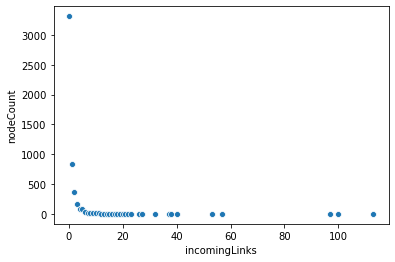

In [7]:
sns.scatterplot(data=link_count_df, y="nodeCount", x="incomingLinks")

In [8]:
link_count_df['incomingLinksPlusOne'] = link_count_df['incomingLinks'] + 1

[None, None]

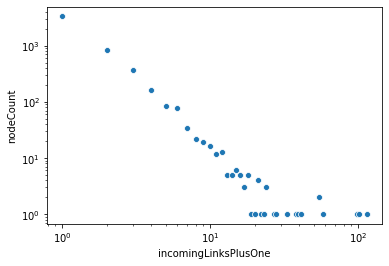

In [9]:
ax = sns.scatterplot(data=link_count_df, y="nodeCount", x="incomingLinksPlusOne")
ax.set(xscale="log", yscale="log")

In [10]:
long_tail_query = """MATCH (p:Page)
OPTIONAL MATCH (p)<-[:LINKS_TO]-(s)
WITH p, count(s) AS incomingLinks
WITH p.p AS probability, incomingLinks, count(p) AS nodeCount
ORDER BY probability, incomingLinks
WITH probability, collect(incomingLinks) AS linkCounts, collect(nodeCount) as nodeCounts
UNWIND RANGE(0, size(linkCounts)-1) as rowNumber
RETURN probability, 
apoc.coll.sum(nodeCounts[rowNumber..]) as nodeCount, 
linkCounts[rowNumber] as linkCount"""

In [11]:
long_tail_df = query_to_pandas(driver, long_tail_query)

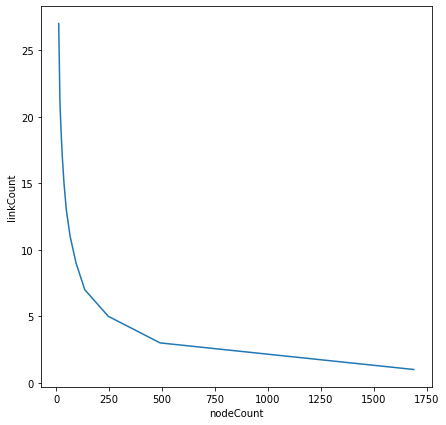

In [12]:
f, ax = plt.subplots(figsize=(7,7))
sns.lineplot(data=long_tail_df[(long_tail_df['nodeCount']>10)
                              & (long_tail_df['linkCount'])>0], y="linkCount", x="nodeCount")